# Using the GmshJL package

In [33]:
using Revise
using GmshJL
using CairoMakie
using ColorSchemes

## Introduction

The `GmshJL` package provides a simple interface to a mesh generated by the Gmsh application. Gmsh allows the definition of so called [physical groups](https://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups). Accordingly, `GmshJL` can be used in a simple mode (no physical groups) and an advanced mode (with physical groups). The differences are explained in the following two sections.

Warnings:

* Implementation is neither fast, memory efficient or complete
* Use is limited to moderately sized 2D meshes. Triangular and quadrilateral elements can not be mixed

## Simple mode (no physical groups defined)

The mesh is constructed by the function `FEMesh(<filename>)` use `plotmesh(<mesh>)` in order to display the mesh.

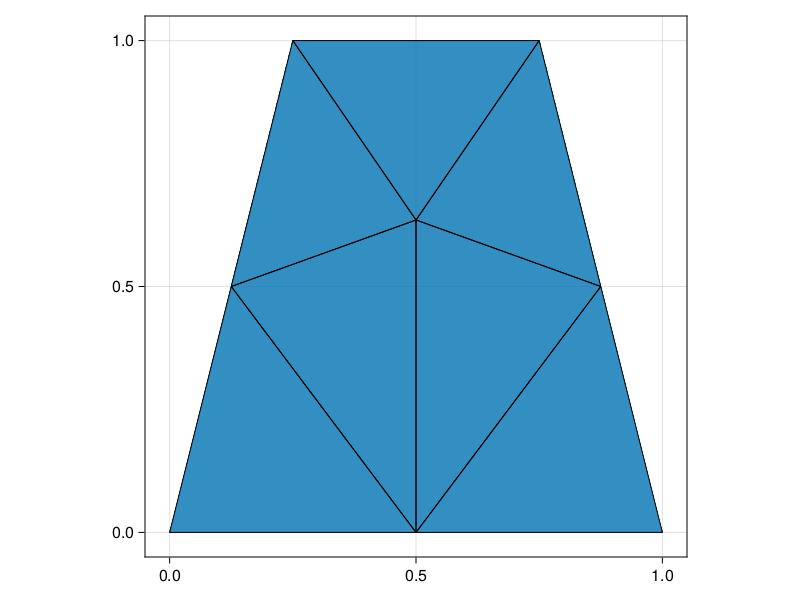

In [2]:
m1 = FEMesh("../data/simple.msh");
plot(m1)

The `FEMesh` object provides access to
* the number of nodes $N_\mathrm{n}$ and node coordinates
* the number of elements $N_\mathrm{e}$ and elements
* IDs of nodes located on the boundary
* ID of a node at a certain position (not yet!)

In [3]:
println("Number of nodes: ", m1.Nn)
println("Node coordinates:\n", m1.nodes)
println("Number of elements: ", m1.Ne)
println("Elements:\n", m1.elements)
println("Boundary node IDs:\n", m1.boundaryNodeIDs)
# println("ID of node at (0.75, 1):\n", m1.findNodeAt(0.75, 1.0))

Number of nodes: 8
Node coordinates:


[0.0 1.0 0.75 0.25 0.5000000000000006 0.8750000000000001 0.1250000000000001 0.5000000000000001; 0.0 0.0 1.0 1.0 0.0 0.4999999999999994 0.5000000000000006 0.6352040816326533]
Number of elements: 7
Elements:
[5 6 7 2 3 7 4; 8 8 1 6 8 8 8; 7 5 5 5 6 4 3]
Boundary node IDs:


[1, 5, 2, 6, 3, 4, 7]


The mesh can be associated with any kind of properties (via the `VarStructs` package). Here an example, where we set a function `f`:

In [4]:
m1.f = sin
println("m1.f(π/2) = ", m1.f(π / 2))

m1.f(π/2) = 1.0


In order to test if a property is defined, one can use the `haskey` function (note the : in front of the property name):

In [5]:
println("Mesh has property f: ", haskey(m1, :f))
println("Mesh has property x: ", haskey(m1, :x))

Mesh has property f: true
Mesh has property x: false


A slightly more complex example illustrates nodes on edges (with an additional plot).

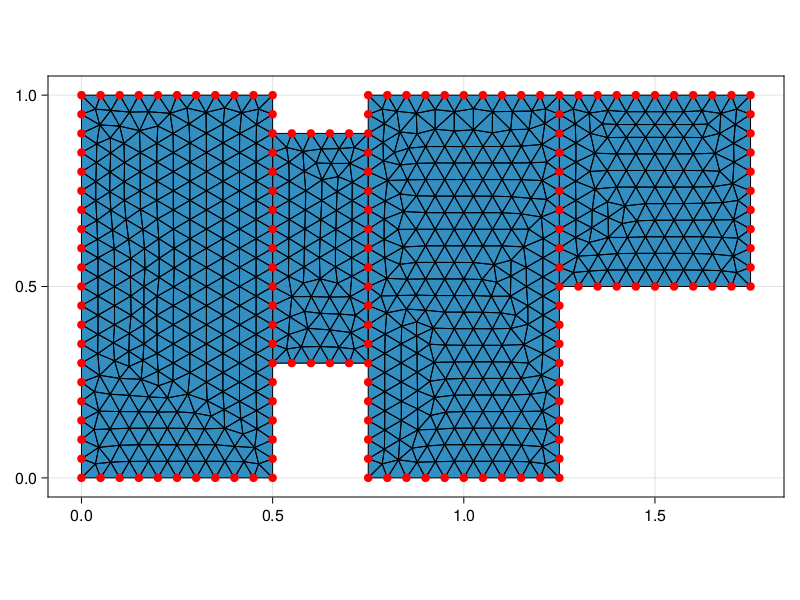

In [6]:
m2 = FEMesh("../data/complex-ng.msh");
f, ax, _ = plot(m2)
scatter!(ax, m2.nodes[:, m2.boundaryNodeIDs], color = :red)
f

Values specified as second parameter to plotmesh with be mapped to colors.

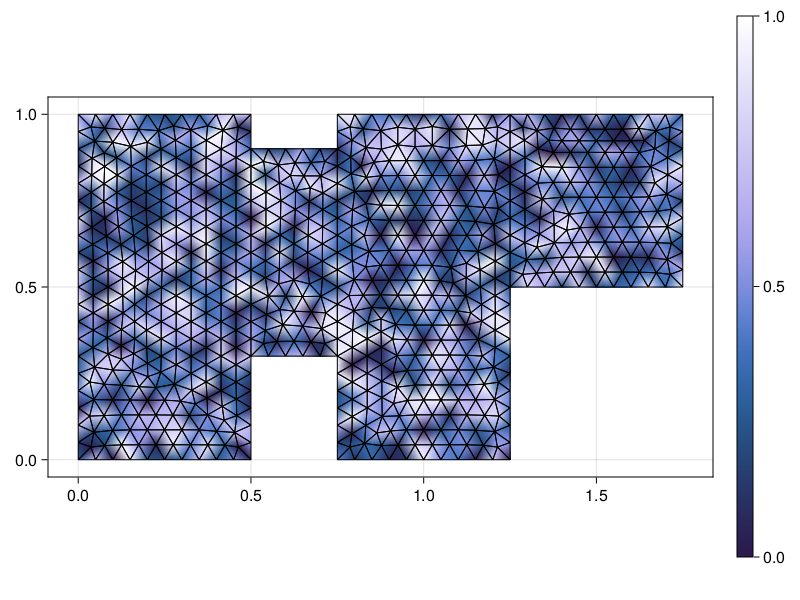

In [7]:
v = rand(m2.Nn)
plot(m2, v)

## Advanced mode: Mesh has physical groups

The mesh is loaded as before. However, in the plot, surfaces and edges are colored according to the physical group.

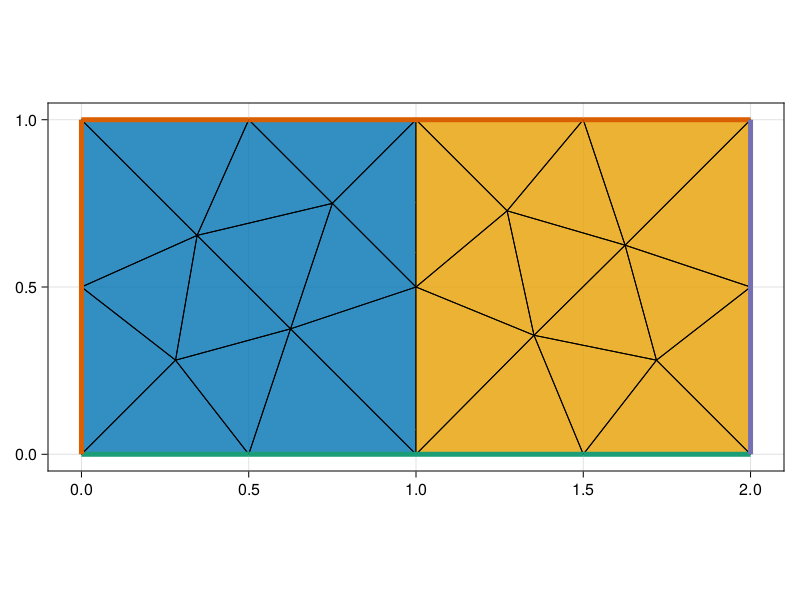

In [8]:
m3 = FEMesh("../data/advanced.msh")
plot(m3)

Again, scalar values can be associated with the nodes and plotted.

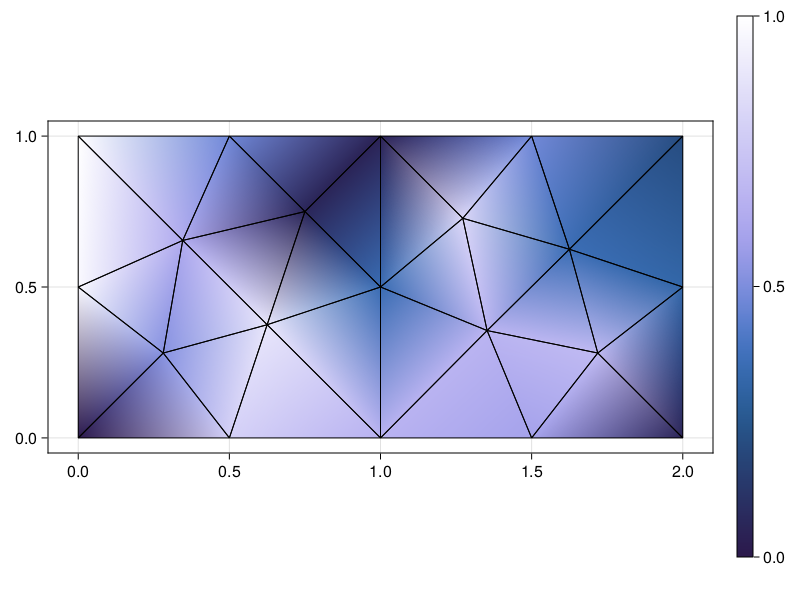

In [45]:
plot(m3, rand(m3.Nn))

Different color schemes can be used as well.

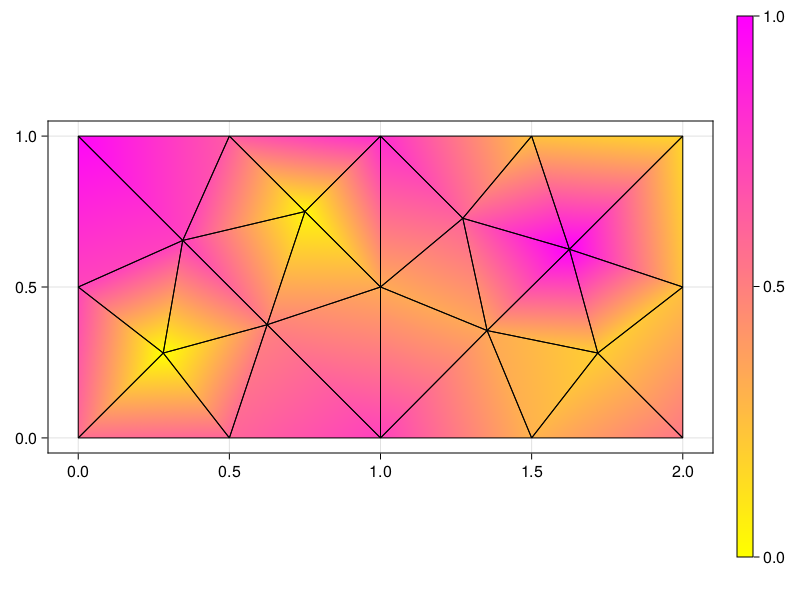

In [44]:
plot(m3, rand(m3.Nn), colors=reverse(ColorSchemes.spring))

In this example, there are three groups of 1D and two groups of 2D elements as defined in the file `data/advanced.geo`. The groups are a property of the mesh object, technically speaking, it is a Julia `Dict` which maps keys to values. Correspondingly, the defined names are accessed by

In [10]:
keys(m3.groups)

KeySet for a Dict{String, GmshJL.Group} with 7 entries. Keys:
  "c2"
  "c1"
  "s1"
  "c3"
  "s2"
  "_faces"
  "_edges"

In addition to the names in the .geo file, there are to logical groups for edges and faces. Groups are accessed by its name:

In [11]:
g = m3.groups["c1"]
println("    Name: ", g.name)
println("      Ne: ", g.Ne)
println("Elements: ", g.elements)
println("Node IDs: ", g.nodeIDs)

    Name: c1
      Ne: 6
Elements: [3 9 4 10 6 13; 9 4 10 1 13 3]
Node IDs: [3, 9, 4, 10, 1, 6, 13]


All groups can be processed in a loop:

In [12]:
for g ∈ values(m3.groups)
    println(g.name, " --> ", g.elements)
end

c2 --> [1 7 2 11; 7 2 11 5]
c1 --> [3 9 4 10 6 13; 9 4 10 1 13 3]
s1 --> [2 8 4 10 7 1 3 9 14 9 14 15 16 15; 15 15 17 17 16 16 14 14 17 17 15 17 17 16; 7 2 9 4 1 10 8 3 15 14 8 16 10 7]
c3 --> [5 12; 12 6]
s2 --> [11 6 13 2 5 12 8 3 11 18 20 19 18 8; 20 19 19 20 21 21 18 18 21 19 21 21 20 20; 2 12 6 8 11 5 3 13 20 13 19 12 19 18]
_faces --> [2 8 4 10 7 1 3 9 14 9 14 15 16 15 11 6 13 2 5 12 8 3 11 18 20 19 18 8; 15 15 17 17 16 16 14 14 17 17 15 17 17 16 20 19 19 20 21 21 18 18 21 19 21 21 20 20; 7 2 9 4 1 10 8 3 15 14 8 16 10 7 2 12 6 8 11 5 3 13 20 13 19 12 19 18]
_edges --> [1 7 3 9 4 10 2 11 5 12 6 13; 7 2 9 4 10 1 11 5 12 6 13 3]


As with the mesh, we can associate properties with groups.

In [21]:
g.f = cos
println("cos(π) = ", m3.groups["c1"].f(π))

cos(π) = -1.0


### Gmsh and physical groups

It is important to understand that Gmsh, if physical groups are defined, by default only exports elements which are attached to at least one physical group (see second paragraph in [Section 6.2 of the Gmsh documentation](https://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups)). Note that the `Mesh.SaveAll=1` option currently does not work with `FEMesh`.

The following two examples illustrate this behaviour. 

#### Example 1

In `data/complex-g1.geo`, there are physical names for three edges and all surfaces defined.

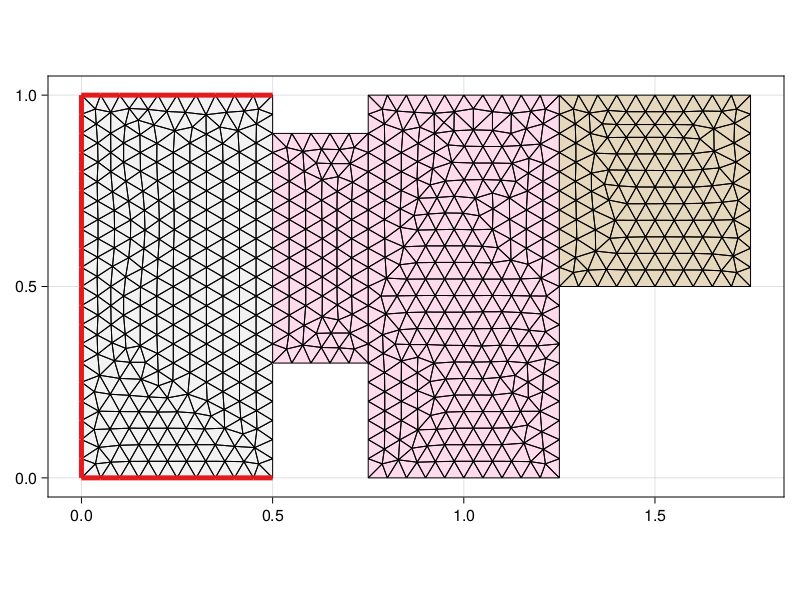

In [25]:
m4 = FEMesh("../data/complex-g1.msh")
plot(m4)

#### Example 2

In `data/complex-g2.geo`, there are physical names for 6 edges but only some of the surfaces defined.

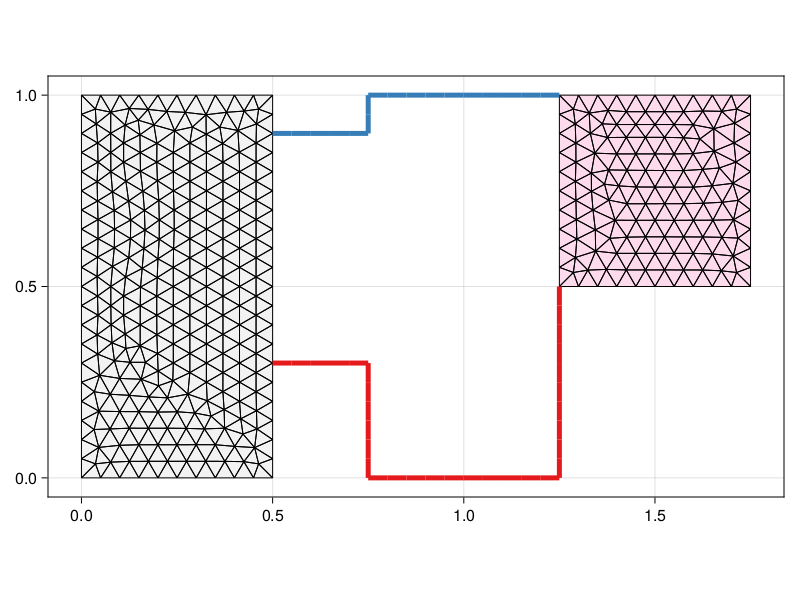

In [26]:
m5 = FEMesh("../data/complex-g2.msh")
plot(m5)